# Evaluation of Benzene DFT by GPAW
This notebook compares HORTON fitting unconstrained and constrained, weighted by all-electron density and superposed single-atom electron dnesities for Benzene

In [1]:
import glob
import re

In [2]:
from fitESPconstrained import *

In [3]:
from ase.build import molecule
from ase.visualize import view

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
benzene = molecule('C6H6')

In [5]:
for a in benzene:
    print(a)

Atom('C', [0.0, 1.395248, 0.0], index=0)
Atom('C', [1.2083200000000001, 0.69762400000000002, 0.0], index=1)
Atom('C', [1.2083200000000001, -0.69762400000000002, 0.0], index=2)
Atom('C', [0.0, -1.395248, 0.0], index=3)
Atom('C', [-1.2083200000000001, -0.69762400000000002, 0.0], index=4)
Atom('C', [-1.2083200000000001, 0.69762400000000002, 0.0], index=5)
Atom('H', [0.0, 2.4823599999999999, 0.0], index=6)
Atom('H', [2.1497869999999999, 1.2411799999999999, 0.0], index=7)
Atom('H', [2.1497869999999999, -1.2411799999999999, 0.0], index=8)
Atom('H', [0.0, -2.4823599999999999, 0.0], index=9)
Atom('H', [-2.1497869999999999, -1.2411799999999999, 0.0], index=10)
Atom('H', [-2.1497869999999999, 1.2411799999999999, 0.0], index=11)


In [181]:
view(benzene,viewer='ngl')

HBox(children=(NGLWidget(), VBox(children=(Dropdown(description='Show', options=('All', 'H', 'C'), value='All'), FloatSlider(value=0.8, description='Ball size', max=1.5, step=0.01)))))

In [34]:
from ase.io import read
from gpaw import GPAW

In [35]:
from ase.optimize.bfgslinesearch import BFGSLineSearch #Quasi Newton


In [36]:
benzene.set_cell([15,15,15])
benzene.set_pbc([0,0,0])
benzene.center()
calc  = GPAW(xc='PBE', h=0.2, charge=0,
             spinpol=True, convergence={'energy': 0.001})



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.3.1b1
 |___|_|             

User:   fr_jh1130@login1.nemo.privat
Date:   Tue May 22 13:46:38 2018
Arch:   x86_64
Pid:    163427
Python: 3.6.3
gpaw:   /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/gpaw/1.3.0/lib/python3.6/site-packages/gpaw
_gpaw:  /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/gpaw/1.3.0/lib/python3.6/site-packages/
       _gpaw.cpython-36m-x86_64-linux-gnu.so
ase:    /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/ase/3.15.0/lib/python3.6/site-packages/ase-3.15.0-py3.6.egg/ase (version 3.15.0)
numpy:  /opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/numpy (version 1.13.3)
scipy:  /opt/bwhpc/common/devel/python/3.6.3.20171114/lib/python3.6/site-packages/scipy (version 1.0.0)
units:  Angstrom and eV
cores:  1

Input parameters:
  convergence: {energy: 0.001}
  h: 0.2
  spinpol: True
  xc: PBE



In [37]:
benzene.set_calculator(calc)

In [38]:
dyn = BFGSLineSearch(benzene, trajectory='benzene/benzene.traj',
                     restart='benzene/bfgs_ls.pckl', logfile='benzene/BFGSLinSearch.log')

In [39]:
type(dyn)

ase.optimize.bfgslinesearch.BFGSLineSearch

In [61]:
# dyn.run(fmax=0.05) # too intense, outsourced parallely

DFT outsourced, see 'benzene/log.sh' and files within 'benzene/dft'

# Fit

Data prepared with
```
# with weights from all electron density
./loop-esp-cost.sh --esp-infile-cube benzene/dft/benzene_vHtg.cube \
  --dens-infile-cube benzene/dft/benzene_rho.cube \
  --cost-outfile-hdf5 benzene/wdens/benzene.cost.lnrhoref \
  --weights-outfile-cube benzene/wdens/benzene.weights.lnrhoref \
  2>&1 | tee benzene/wdens/benzene.loop-esp-cost.log
  
# with weights from all electron density and inverted sign convention
./loop-esp-cost.sh --esp-infile-cube benzene/dft/benzene_vHtg.cube \
  --dens-infile-cube benzene/dft/benzene_rho.cube \
  --cost-outfile-hdf5 benzene/wdens_neg/benzene.cost.lnrhoref \
  --weights-outfile-cube benzene/wdens_neg/benzene.weights.lnrhoref \
  --sign 2>&1 | tee benzene/wdens_neg/benzene.loop-esp-cost.log
  
# with weights from superposed single-atom electron densities
./loop-esp-cost.sh --esp-infile-cube benzene/dft/benzene_vHtg.cube \
  --cost-outfile-hdf5 benzene/nowdens/benzene.cost.lnrhoref \
  --weights-outfile-cube benzene/nowdens/benzene.weights.lnrhoref \
  2>&1 | tee benzene/nowdens/benzene.loop-esp-cost.log
  
# with weights from superposed single-atom electron densities 
# and inverted sign convention
./loop-esp-cost.sh --esp-infile-cube benzene/dft/benzene_vHtg.cube \
  --cost-outfile-hdf5 benzene/nowdens_neg/benzene.cost.lnrhoref \
  --weights-outfile-cube benzene/nowdens_neg/benzene.weights.lnrhoref \
  --sign 2>&1 | tee benzene/nowdens_neg/benzene.loop-esp-cost.log

```

Fits automized with
```
module purge 
module load gpaw

# with weights from all electron density
./loop-fitESPforBenzene.sh -i benzene/wdens/benzene.cost.lnrhoref \
  -o benzene/wdens/benzene.charges.lnrhoref \
  2>&1 | tee benzene/wdens/loop-fitESPforBenzene.log 

# with weights from all electron density and inverted sign convention
./loop-fitESPforBenzene.sh -i benzene/wdens_neg/benzene.cost.lnrhoref \
  -o benzene/wdens_neg/benzene.charges.lnrhoref \
  2>&1 | tee benzene/wdens_neg/loop-fitESPforBenzene.log 

# with weights from superposed single-atom electron densities
./loop-fitESPforBenzene.sh -i benzene/nowdens/benzene.cost.lnrhoref \
  -o benzene/nowdens/benzene.charges.lnrhoref \
  2>&1 | tee benzene/nowdens/loop-fitESPforBenzene.log 

# with weights from superposed single-atom electron densities 
# and inverted sign convention
./loop-fitESPforBenzene.sh -i benzene/nowdens_neg/benzene.cost.lnrhoref \
  -o benzene/nowdens_neg/benzene.charges.lnrhoref \
  2>&1 | tee benzene/nowdens_neg/loop-fitESPforBenzene.log 
```

## Supporting functions

In [55]:
number_regexp = '[-+]?[0-9]+(?:\.[0-9]+)?'
convert = lambda text: float(text) if re.match('^' + number_regexp + '$', text) else text
alphanum = lambda key: [ convert(c) for c in re.split('(' + number_regexp + ')', key) ]

In [182]:
def costFunction(X,A,B,C,N):
    return np.dot(np.dot(X[:N].T,A),X[:N]) - np.dot(B,X[:N])

## Evaluate parameter sweeps

In [183]:
set_names = ['Weights constructed by all-electron density',
            'Weights constructed by all-electron density, inverse sign convention',
            'Weights constructed by superposed single-atom electron densities',
            'Weights constructed by superposed single-atom electron densities, inverse sign convention']
directories = ['benzene/wdens/', 'benzene/wdens_neg/', 
               'benzene/nowdens/', 'benzene/nowdens_neg/']

In [93]:
benzene_cost_fn_files = []
all_X_constrained = []
all_X_unconstrained = []
all_cost_fn_val_unconstrained = []
all_cost_fn_val_constrained = []
all_parameters = []
all_benzenes = []
average_C_charge = []
average_H_charge = []
variance_C_charge = []
variance_H_charge = []

for i, d in enumerate(directories):
    benzene_cost_fn_files.append( glob.glob(d + "*.cost.*.h5") )
    benzene_cost_fn_files[i].sort(key=alphanum)
    print("#{:d}: Folder {:s}, found {:d} files:".format(i, d, len(benzene_cost_fn_files[i])))
    # extract parameter from file name
    parameter = []
    for f in benzene_cost_fn_files[i]:
        parts = alphanum(f)
        for p in parts:
            if isinstance(p, float):
                parameter.append(p)
                break
    
    all_parameters.append( parameter )
    all_X_constrained.append([])
    all_X_unconstrained.append([])
    all_cost_fn_val_unconstrained.append([])
    all_cost_fn_val_constrained.append([])
    average_C_charge.append([])
    average_H_charge.append([])  
    variance_C_charge.append([])
    variance_H_charge.append([])
    all_benzenes.append([])
    
    #print("#{:d}: Folder {:s}, processing {:d} files:".format(i,d,len(parameter)))
    for l in zip(benzene_cost_fn_files[i],parameter):
        print("ln(rho_ref) = {:>+3.0f}: ".format(l[1]),
              "{:s}".format(l[0]))
    

    for f in benzene_cost_fn_files[i]:
        A_horton, B_horton, C_horton, N_horton = \
                read_horton_cost_function(file_name = f)

        X_unconstrained, A_unconstrained, B_unconstrained = \
                    unconstrainedMinimize(A_matrix = A_horton,
                                b_vector = B_horton,
                                C_scalar = C_horton,
                                debug    = False)
        D,q = constructTotalChargeConstraint(N=N_horton,charge=0)

        X, A, B = constrainedMinimize(A_matrix = A_horton,
                                b_vector = B_horton,
                                C_scalar = C_horton,
                                D_matrix = D, 
                                q_vector = q,
                                debug    = False)

        cost_fn_val_unconstrained = costFunction(X_unconstrained,
                                                 A_horton,B_horton,
                                                 C_horton,N_horton) 
        cost_fn_val_constrained = costFunction(X,A_horton,B_horton,
                                               C_horton,N_horton)

        all_X_unconstrained[i].append( X_unconstrained )
        all_X_constrained[i].append( X )
        all_cost_fn_val_unconstrained[i].append( cost_fn_val_unconstrained )
        all_cost_fn_val_constrained[i].append( cost_fn_val_constrained )
        
        new_benzene = benzene.copy()
        for j, a in enumerate(new_benzene):
            a.charge = X[j]
            
        is_C = [ a.symbol == 'C' for a  in new_benzene ]
        is_H = [ a.symbol == 'H' for a  in new_benzene ]

        C_charges = [ a.charge for a in new_benzene[is_C] ]
        H_charges = [ a.charge for a in new_benzene[is_H] ]
        
        average_C_charge[i].append( np.mean(C_charges) )
        average_H_charge[i].append( np.mean(H_charges) )
        variance_C_charge[i].append( np.var(C_charges) )
        variance_H_charge[i].append( np.var(H_charges) )
        
        all_benzenes[i].append(new_benzene)


#0: Folder benzene/wdens/, found 22 files:
ln(rho_ref) = -18:  benzene/wdens/benzene.cost.lnrhoref.-18.h5
ln(rho_ref) = -17:  benzene/wdens/benzene.cost.lnrhoref.-17.h5
ln(rho_ref) = -16:  benzene/wdens/benzene.cost.lnrhoref.-16.h5
ln(rho_ref) = -15:  benzene/wdens/benzene.cost.lnrhoref.-15.h5
ln(rho_ref) = -14:  benzene/wdens/benzene.cost.lnrhoref.-14.h5
ln(rho_ref) = -13:  benzene/wdens/benzene.cost.lnrhoref.-13.h5
ln(rho_ref) = -12:  benzene/wdens/benzene.cost.lnrhoref.-12.h5
ln(rho_ref) = -11:  benzene/wdens/benzene.cost.lnrhoref.-11.h5
ln(rho_ref) = -10:  benzene/wdens/benzene.cost.lnrhoref.-10.h5
ln(rho_ref) =  -9:  benzene/wdens/benzene.cost.lnrhoref.-9.h5
ln(rho_ref) =  -8:  benzene/wdens/benzene.cost.lnrhoref.-8.h5
ln(rho_ref) =  -7:  benzene/wdens/benzene.cost.lnrhoref.-7.h5
ln(rho_ref) =  -6:  benzene/wdens/benzene.cost.lnrhoref.-6.h5
ln(rho_ref) =  -5:  benzene/wdens/benzene.cost.lnrhoref.-5.h5
ln(rho_ref) =  -4:  benzene/wdens/benzene.cost.lnrhoref.-4.h5
ln(rho_ref) =  -3:

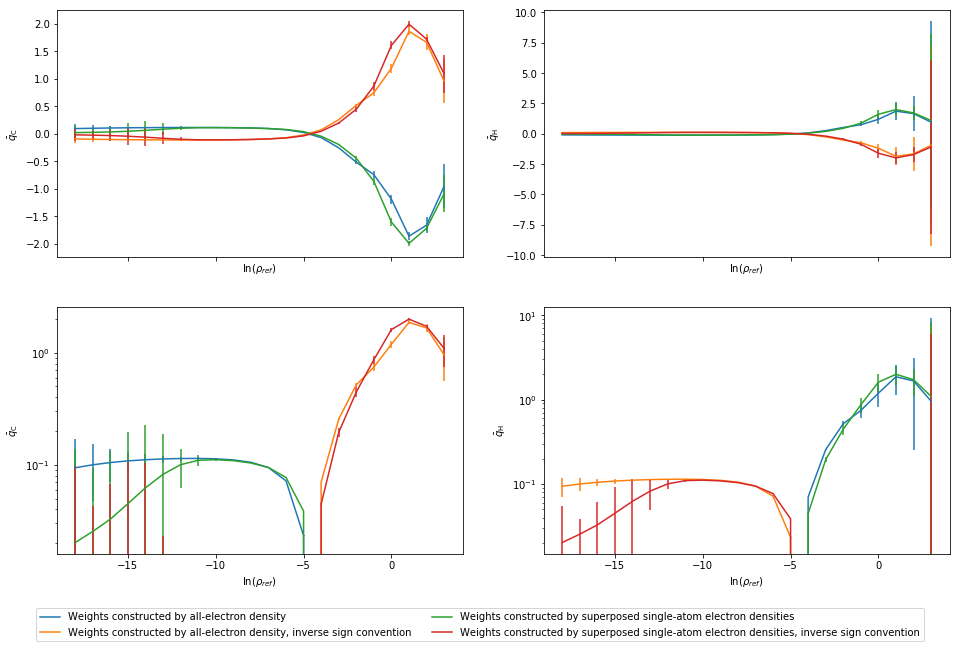

In [180]:
# plot results
cols = 2
rows = 2
all_avCch_graphs = []
fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(cols*8,rows*5))
for i in range(len(all_benzenes)):
    
    avCch_graph = axs[0,0].errorbar(all_parameters[i],average_C_charge[i],yerr=np.sqrt(variance_C_charge[i]))
    axs[0,0].set_ylabel(r'$\bar{q}_\mathrm{C}$')
    axs[0,0].set_xlabel(r'$\ln(\rho_{ref})$')
        
    axs[0,1].errorbar(all_parameters[i],average_H_charge[i],yerr=np.sqrt(variance_H_charge[i]))
    axs[0,1].set_ylabel(r'$\bar{q}_\mathrm{H}$')
    axs[0,1].set_xlabel(r'$\ln(\rho_{ref})$') 
    
    axs[1,0].set_yscale("log", nonposy='clip')
    axs[1,0].errorbar(all_parameters[i],average_C_charge[i],yerr=np.sqrt(variance_C_charge[i]))
    axs[1,0].set_ylabel(r'$\bar{q}_\mathrm{C}$')
    axs[1,0].set_xlabel(r'$\ln(\rho_{ref})$')
    
    axs[1,1].set_yscale("log", nonposy='clip')
    axs[1,1].errorbar(all_parameters[i],average_H_charge[i],yerr=np.sqrt(variance_H_charge[i]))
    axs[1,1].set_ylabel(r'$\bar{q}_\mathrm{H}$')
    axs[1,1].set_xlabel(r'$\ln(\rho_{ref})$')
    
    

        
    all_avCch_graphs.append(avCch_graph)
#plt.show()    

lines = [a.lines[0] for a in all_avCch_graphs ]
fig.legend( lines, set_names, loc='lower center', ncol=cols )

In [44]:
smamp_esp_cube = 'sandbox/system100.vHtg_ua.cube'
smamp_esp_cube_data, smamp_esp_cube_atoms = read_cube_data(smamp_esp_cube)

In [45]:
benzene_esp_cube = 'benzene/benzene.esp.cube'
benzene_esp_cube_data, benzene_esp_cube_atoms = read_cube_data(benzene_esp_cube)

In [46]:
smamp_esp_cube_data.min(),smamp_esp_cube_data.max()

(-11.739050000000001, 0.0)

In [47]:
benzene_esp_cube_data.min(),benzene_esp_cube_data.max()

(-10.171620000000001, 0.0)

In [ ]:
# SMAMP

In [77]:
infile_cost_h5 = "sandbox/system100.cost_ua.h5"

In [ ]:
A_horton, B_horton, C_horton, N_horton = \
        read_horton_cost_function(file_name = infile_cost_h5)

# Weights
TO BE EXTENDED

In [103]:
benzene_weights_cube = 'benzene/benzene.weights.lnrhoref.-9.cube'

In [104]:
benzene_weights_cube_data, benzene_weights_cube_atoms = read_cube_data(benzene_weights_cube)

In [109]:
benzene_weights_cube_data.sum()

185277.72807677457

In [159]:
benzene_wdens_weight_files = glob.glob("./benzene/wdens/*.weights.*.cube")

In [160]:
for f in benzene_wdens_weight_files:
    print(alphanum(f))

['./benzene/wdens/benzene.weights.lnrhoref.', -13.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -6.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -1.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -15.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -14.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', 0.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -2.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -5.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -9.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -17.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', 2.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -10.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', 1.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -8.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -11.0, '.cube']
['./benzene/wdens/benzene.weights.lnrhoref.', -7.0, '.cube']
['./benzene/wdens/ben

In [162]:
benzene_wdens_weight_files.sort(key=alphanum)

In [163]:
benzene_wdens_weight_files

['./benzene/wdens/benzene.weights.lnrhoref.-18.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-17.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-16.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-15.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-14.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-13.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-12.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-11.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-10.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-9.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-8.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-7.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-6.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-5.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-4.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-3.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-2.cube',
 './benzene/wdens/benzene.weights.lnrhoref.-1.cube',
 './benzene/wdens/benzene.weights.lnr

In [174]:
parameter = []
for f in benzene_wdens_weight_files:
    parts = alphanum(f)
    for p in parts:
        if isinstance(p, float):
            parameter.append(p)

In [175]:
parameter

[-18.0,
 -17.0,
 -16.0,
 -15.0,
 -14.0,
 -13.0,
 -12.0,
 -11.0,
 -10.0,
 -9.0,
 -8.0,
 -7.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0]

In [178]:
benzene_weights_cube_data = []
benzene_weights_cube_atoms = []

In [179]:
for file in benzene_wdens_weight_files: 
    tmp_data, tmp_atoms = read_cube_data(file)
    benzene_weights_cube_data.append(tmp_data)
    benzene_weights_cube_atoms.append(tmp_atoms)

In [ ]:
for be

In [180]:
benzene_nowdens_weight_files = glob.glob("./benzene/nowdens/*.weights.*.cube")

In [181]:
benzene_nowdens_weight_files.sort(key=alphanum)

In [182]:
nowdens_parameter = []
for f in benzene_nowdens_weight_files:
    parts = alphanum(f)
    for p in parts:
        if isinstance(p, float):
            nowdens_parameter.append(p)

In [183]:
benzene_nowdens_weights_cube_data = []
benzene_nowdens_weights_cube_atoms = []

In [184]:
for file in benzene_nowdens_weight_files: 
    tmp_data, tmp_atoms = read_cube_data(file)
    benzene_nowdens_weights_cube_data.append(tmp_data)
    benzene_nowdens_weights_cube_atoms.append(tmp_atoms)

In [186]:
len(benzene_nowdens_weights_cube_data)

22

In [187]:
len(benzene_weights_cube_atoms)

22

In [201]:
for i in range(0,len(benzene_nowdens_weights_cube_atoms)):
    print("ln(rho_ref) = {:>+3.0f}: ".format(parameter[i]),
          "nowdens min(w) = {:>8.4e}, ".format(
             benzene_nowdens_weights_cube_data[i].min() ),
          "max(w) = {:>8.4e}, ".format(
             benzene_nowdens_weights_cube_data[i].max() ),
          "sum(w) = {:>8.4e}".format(
         benzene_nowdens_weights_cube_data[i].sum() ) )
    print("{:>21s} wdens min(w) = {:>8.4e}, ".format("",
             benzene_weights_cube_data[i].min() ),
          "max(w) = {:>8.4e}, ".format(
             benzene_weights_cube_data[i].max() ),
          "sum(w) = {:>8.4e}".format(
         benzene_weights_cube_data[i].sum() ) )

ln(rho_ref) = -18:  nowdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 8.2568e+05
                      wdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 8.4294e+04
ln(rho_ref) = -17:  nowdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 8.0048e+05
                      wdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 7.9012e+04
ln(rho_ref) = -16:  nowdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 7.7514e+05
                      wdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 7.3888e+04
ln(rho_ref) = -15:  nowdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 7.4906e+05
                      wdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 6.8925e+04
ln(rho_ref) = -14:  nowdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 7.2523e+05
                      wdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) = 6.4126e+04
ln(rho_ref) = -13:  nowdens min(w) = 0.0000e+00,  max(w) = 1.0000e+00,  sum(w) =

In [205]:
parameter[9]

-9.0

In [206]:
benzene_nowdens_weights_cube_atoms[9].cell

array([[ 25.00005443,   0.        ,   0.        ],
       [  0.        ,  25.00005443,   0.        ],
       [  0.        ,   0.        ,  25.00005443]])

In [223]:
pplotSection2D(benzene_nowdens_weights_cube_data[9],benzene_nowdens_weights_cube_atoms[9], position=10.0)

IndexError: list index out of range

In [220]:
def cube2xyz(cube_data, cube_atoms, outfile_dat="", print_range="", x_coord="", y_coord="", 
    z_coord="", mpl=True, aa=1.0, output=True, p_label=" (a.u.)", show_plot=False, ax=False ):
    import sys, os
    import numpy as np
    from ase.units import Bohr


    print("Options: \n",
        "{:>20}:{:>20}\n".format("outfile_dat",outfile_dat), 
        "{:>20}:{:>20}\n".format("print_range",print_range),
        "{:>20}:{:>20}\n".format("x_coord",x_coord),
        "{:>20}:{:>20}\n".format("y_coord",y_coord),
        "{:>20}:{:>20}\n".format("z_coord",z_coord),
        "{:>20}:{!s:>20}\n".format("mpl",mpl),
        "{:>20}:{:20.2e}\n".format("aa",aa),
        "{:>20}:{!s:>20}\n".format("output",output),
        "{:>20}:{:>20}\n".format("p_label",p_label) )
    at_coord=[]
    spacing_vec=[]
    nline=0
    values=[]
    fig=0
    # Read cube file and parse all data
    # for line in open(infile_cube,"r"):
    #    nline+=1
    #    if nline==3:
    #        try:
    #            nat=int(line.split()[0]) 
    #            origin=[float(line.split()[1]),
    ##                float(line.split()[2]),float(line.split()[3])]
    #        except:
    #            print("ERROR: non recognized cube format")
    #    elif nline >3 and nline <= 6:
    #        spacing_vec.append(line.split())
    #    elif nline > 6 and nline <= 6+nat:
    #        at_coord.append(line.split())
    #    elif nline > 5:
    #        if nline > 6+nat:
    #            for i in line.split():
    #                values.append(float(i)) 
    nat = cube_atoms.get_number_of_atoms()
    # spacing_vec = cube_atoms.cell / cube_data.shape / Bohr
    # just for now: ugly matrix of shape and spacing
    spacing_vec = np.hstack([np.atleast_2d(cube_data.shape).T,
                             cube_atoms.cell / cube_data.shape / Bohr])
    # at_coord = cube_atoms.get_positions() / Bohr
    at_coord = np.hstack( 
        [ np.atleast_2d(cube_atoms.get_atomic_numbers()).T, 
         np.zeros( ( cube_atoms.get_number_of_atoms(), 1) ),
         cube_atoms.get_positions() / Bohr ] )

    values = cube_data.flatten()
    
    # print(" ")
    def frange(x, y, jump):
        while x < y:
            yield x
            x += jump

    idx=-1

    if print_range != "":
        print(print_range+" range:")
        if print_range == "x":
            for i in range(0,int(spacing_vec[0][0])):
                print(i*float(spacing_vec[0][1])*aa)
        if print_range == "y":
            for i in range(0,int(spacing_vec[1][0])):
                print(i*float(spacing_vec[1][2])*aa)
        if print_range == "z":
            for i in range(0,int(spacing_vec[2][0])):
                print(i*float(spacing_vec[2][3])*aa)
            sys.exit()


    filter=""  # Create a filter for the values on a segment or plane
    if x_coord != "":
        filter=filter+ " x > " \
            + str(float(x_coord)-float(spacing_vec[0][1])+0.1) + " and x < " \
            + str(float(x_coord)+float(spacing_vec[0][1])-0.1) + " "
    if y_coord != "":
        if x_coord != "": 
            filter=filter+" and "
        filter=filter+ " y > " \
            + str(float(y_coord)-float(spacing_vec[1][2])+0.1)+" and y < " \
            + str(float(y_coord)+float(spacing_vec[1][2])-0.1) + " "
    if z_coord != "":
        if len(filter)> 3:
            filter=filter+" and "
        filter=filter+ " z > " \
            + str(float(z_coord)-float(spacing_vec[2][3])+0.1) + " and z < " \
            + str(float(z_coord)+float(spacing_vec[2][3])-0.1) + " "
    if filter=="":
        filter="1==1"
        
    print("Filter: {}".format(filter))

     # Set parameter for type of plot
    plttmp=[]
    xyzs=""
    if x_coord:
        plttmp.append(x_coord)
        xyzs=xyzs+"x"
    if y_coord:
        plttmp.append(y_coord)
        xyzs=xyzs+"y"
    if z_coord:
        plttmp.append(z_coord)
        xyzs=xyzs+"z"
    plot_dim=4-len(plttmp)
    # print(" Representing "+str(plot_dim)+"D data...", xyzs) 


      #Print x,y,z,value data to stdout, file or not at all
    data=[]
    
    #print("Spacing vectors: {}".format(spacing_vec))

    if outfile_dat and output:
        #if output file name is provided, print to file instead of STD out
        tmp=sys.stdout
        sys.stdout = open(outfile_dat,'w')
    if not output:
        tmp=sys.stdout
        sys.stdout = open(os.devnull, 'w')

    print("Spacing vectors: {}".format(spacing_vec))
    for i in range(0,int(spacing_vec[0][0])):
        for j in range(0,int(spacing_vec[1][0])):
            for k in range(0,int(spacing_vec[2][0])):
                idx+=1
                x,y,z= i*float(spacing_vec[0][1]), \
                    j*float(spacing_vec[1][2]),k*float(spacing_vec[2][3])
                print("Looking at pos ({},{},{}).".format(x,y,z))
                if eval(filter):
                    print(x/aa,y/aa,z/aa, values[idx])
                    data.append([x/aa,y/aa,z/aa, values[idx]])
    
    print("Filtered {} data points.".format(len(data)))

    if outfile_dat or not output:
        sys.stdout.close()
        sys.stdout=tmp

    ylabel="Cube magnitude"
    axe_labels=["x","y","z"]
    if mpl:
        if plot_dim == 4:
            print("4D plot not implemented")
            sys.exit()

        if plot_dim == 3:
            var_axe1=list("xyz".replace(xyzs[0],""))[0]  
            var_axe2=list("xyz".replace(xyzs[0],""))[1]
            print("Plot in 3D: \n",
                "{:>20}:{:>20}\n".format("var_axe1",var_axe1), 
                "{:>20}:{:>20}\n".format("var_axe2",var_axe2),
                "{:>20}:{:>20}\n".format("axe_labels(var_axe1)",
                                         axe_labels.index(var_axe1)),
                "{:>20}:{:>20}\n".format("axe_labels(var_axe2)",
                                         axe_labels.index(var_axe2)),
                "{:>20}:{:>20}\n".format("len(data)", len(data)))
            
            from mpl_toolkits.mplot3d.axes3d import Axes3D
            from matplotlib import cm
            #X, Y =np.meshgrid(zip(*data)[axe_labels.index(var_axe1)],
            #    zip(*data)[axe_labels.index(var_axe2)])
            
            X,Y=list(zip(*data))[axe_labels.index(var_axe1)],\
                list(zip(*data))[axe_labels.index(var_axe2)]
            Z = list(zip(*data))[3]
            #print "max Z: ", max(Z)
            if not ax:
                fig = plt.figure()
                ax = fig.gca(projection='3d')
            
            # plt.hold(True)
            # surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
            #     cmap=cm.coolwarm, linewidth=0, antialiased=False)
            surf = ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0.2)
            fig = ax.figure
            fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
            

            ax.set_xlabel(var_axe1 + p_label)
            ax.set_ylabel(var_axe2 + p_label)
            ax.set_zlabel('Cube property')

            coord=[]
            print("at_coord: {}".format(at_coord))
            for c in at_coord: # Format atomic coordinates for plotting
                 coord.append([(float(c[2]))/aa,(float(c[3]))/aa,(float(c[4]))/aa])

            xc=list(zip(*coord))[axe_labels.index(var_axe1)]
            yc=list(zip(*coord))[axe_labels.index(var_axe2)]
            
            spanZ = max(Z) - min(Z)
            zc=[max(Z)+(spanZ*0.5)]*len(coord) #put atoms slightly higher than max val
            # projection of atoms centers above the graph
            ax.scatter(xc,yc,zc,s=150, c='b', marker='o',cmap=None, norm = None, 
                edgecolors='c', lw=3.0, alpha=1) 
           # for i in coord:

        if plot_dim == 2:  # when 2 variables are fixed a 2D plot is produced
            var_axe= "xyz".replace(xyzs[0],"").replace(xyzs[1],"")
            var_idx=axe_labels.index(var_axe)
            plot(list(zip(*data))[var_idx], list(zip(*data))[3])
            plt.xlabel(var_axe + p_label)
            plt.ylabel("Cube property")

        #plt.grid(True) 
        if show_plot:
            show()   
        
        #if fig:
        #    return fig
        if ax:
            return ax

In [221]:
def plotSection2D(cube_data,cube_atoms, position, axis=0, ax=False):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    from mpl_toolkits.mplot3d import Axes3D
    if not ax:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        
    if axis==0 or axis=="x":
        tmp_ax = cube2xyz(cube_data,cube_atoms, x_coord=position, mpl=True, output=False, show_plot=False, ax=ax)
    elif axis==1 or axis=="y":
        tmp_ax = cube2xyz(cube_data,cube_atoms, y_coord=position, mpl=True, output=False, show_plot=False, ax=ax)
    elif axis==2 or axis=="z":
        tmp_ax = cube2xyz(cube_data,cube_atoms, z_coord=position, mpl=True, output=False, show_plot=False, ax=ax)
        
    return tmp_ax

In [222]:
def sliceXYZ(cube_data,cube_atoms, sections=6, margin_relative=1e-1,cols=2,width=8,height=5):
    from ase.units import Bohr
    #from cube2xyz import cube2xyz
    #from cube2xyz import plotSection2D
    #cube_data, cube_atoms = read_cube_data(infile_cube)
    X = cube_atoms.cell.diagonal()/Bohr
    print("Slicing box of {} Bohr...".format(X))
    margin = margin_relative * X
    #cols = 2
    rows = round(sections/cols)
    print("Displaying {:d} sections in {:d} rows and {:d} cols.".format(sections,rows,cols))

    fig = []
    axes = []
    dim_label= ["x",",y","z"]
    for dim in range(X.shape[0]):
        #L = X.shape[3]
        x = np.linspace(margin[dim],X[dim]-margin[dim],sections)

        print("Processing {} Bohr slices in {} direction...".format(x,dim_label[dim]))

        tmp_fig, tmp_axes = plt.subplots(rows,cols,figsize=(cols*width,rows*height),subplot_kw={'projection':'3d'})
        p = 0
        for i in range(rows):
            for j in range(cols):
                if p < sections:
                    print("Calling cube2xyz.plotSection2D at slice {} = {} Bohr...".format(dim_label[dim],x[p]))

                    tmp_ax = plotSection2D(cube_data,cube_atoms, x[p], axis=dim, ax=tmp_axes[i,j])
                    tmp_ax.set_title(".cube slice at {} = {:.3e} Bohr".format(dim_label[dim],x[p]))
                    #cube2xyz(infile_cube, y_coord=x[p],output=False, mpl=True,ax=axes[i,j])
                    p += 1
                else:
                    break

        fig.append(tmp_fig)
        axes.append(tmp_axes)
        
    return fig